# Load the data files and structure the data

In [1]:
import os
os.chdir("/Users/mphomafata/Documents/GitHub/Chromatographic-data")
import pandas as pd
from scipy.io import netcdf_file
beer_files = sorted(os.listdir("/Users/mphomafata/Documents/Work_file/Collaborative Work/Cody/Untargeted - Gin and Beer/raw_data/Beer/"))
beer_data = []
for beer_file in beer_files[:3]:
    cdf_file = netcdf_file(f'/Users/mphomafata/Documents/Work_file/Collaborative Work/Cody/Untargeted - Gin and Beer/raw_data/Beer/{beer_file}', mmap=False)
    data = pd.DataFrame(columns=["retention_time","mass_values", "intensities"])
    # variables of interest
    mass_values = cdf_file.variables['mass_values'].data
    retention_time = cdf_file.variables['scan_acquisition_time'].data
    point_count = cdf_file.variables['point_count'].data
    
    # cumulative counter 
    def Cumulative(lists): 
        cu_list = [] 
        length = len(lists) 
        cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)] 
        return cu_list[1:]
    lists = point_count
    point_counter = Cumulative(lists)
    
    for i, s in enumerate(retention_time):
        if i==0:
            start = i
        else:
            start = point_counter[i-1]+1
        stop = point_counter[i]
        rt = cdf_file.variables['scan_acquisition_time'][i]
        # print("retention time " + str(rt)+ " has " + str(point_count[i]) + " points starting at " + str(start) + " ending at " + str(stop))
        intensities = cdf_file.variables['intensity_values'][start:stop]
        mass_values = cdf_file.variables['mass_values'][start:stop]
        data.loc[len(data.index)] = [rt,mass_values, intensities]
    data = data.explode(['mass_values','intensities']).reset_index(drop=True)
    # data = data.explode('intensities')
    beer_data.append(data)
    # data.to_excel(f"{beer_file}.xlsx") # too large  to print to excel
    print("Finished sample " + str(beer_files.index(f"{beer_file}") +1) + " of " + str(len(beer_files)))
    # print(f"Sample {beer_file} completed!")
cdf_file .close()


Finished sample 1 of 95
Finished sample 2 of 95
Finished sample 3 of 95


# Peak detection

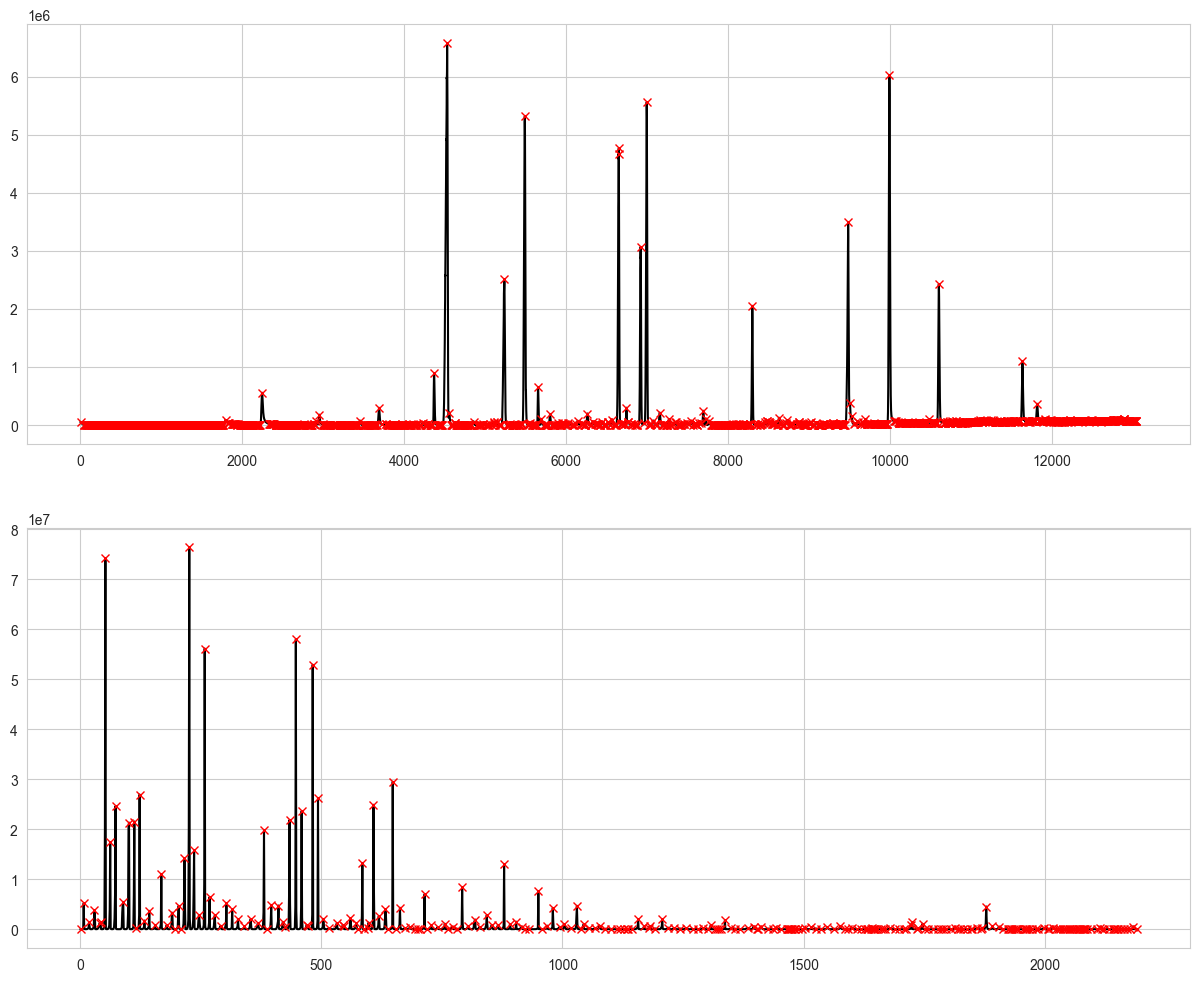

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
x1 = pd.DataFrame(beer_data[0])
x1=x1.groupby(["retention_time"]).aggregate({'intensities':'sum'}).reset_index()
x1=x1["intensities"].reset_index(drop=True)
# x=x.iloc[1500:2500].reset_index(drop=True)
peaks1, _ = find_peaks(x1, width=1)

x2 = pd.DataFrame(beer_data[0])
x2=x2.groupby(["mass_values"]).aggregate({'intensities':'sum'}).reset_index()
x2=x2["intensities"].reset_index(drop=True)
# x=x.iloc[1500:2500].reset_index(drop=True)
peaks2, _ = find_peaks(x2)

fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(2,1,1)
ax1 = plt.plot(x1,'black')
ax1 = plt.plot(peaks1, x1[peaks1], "x",color = 'red') 

ax2 = fig.add_subplot(2,1,2)
ax2 = plt.plot(x2,'black')
ax2 = plt.plot(peaks2, x2[peaks2], "x",color = 'red') 

# beer_data[0]